In [2]:
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

from models import AlexNet, XAlexNet, vgg16, xvgg16, fixup_resnet50, xfixup_resnet50
from utils.visualization import Visualize, show_pil_image, pil_image
from collections import OrderedDict

from captum.attr import Saliency, InputXGradient, IntegratedGradients

import argparse
import os
import time
from utils import AttributionPriorExplainer
import torchvision.datasets as datasets

import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils.visualization import Visualize, show_pil_image, pil_image

## Setup

In [77]:
torch.manual_seed(6)
np.random.seed(4)
device = "cuda:0"
batch_size = 1

model_dict = '/data/rhesse/imagenet_models/' # set this to the dictionary containing your X-DNNs
data_dir = '/fastdata/rhesse/datasets/imagenet/train' # set this to the train split of ImageNet

model = XAlexNet().to(device)
checkpoint = torch.load(model_dict + 'xalexnet_model_best.pth.tar', map_location=device)

# load model and remove preceding "module." because it was stored as DataParallel
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:7] == 'module.':
        name = k[7:]  # remove `module.`
    else:
        name = k
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

# prepare data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])
data = datasets.ImageFolder(
        data_dir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
data_loader = torch.utils.data.DataLoader(
        data, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True)

## Computing Attributions for Evaluation

tensor([225], device='cuda:0')
tensor(12.6229, device='cuda:0', grad_fn=<SelectBackward>)
tensor([[12.6229]], device='cuda:0', grad_fn=<GatherBackward>)


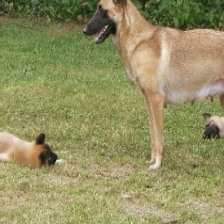

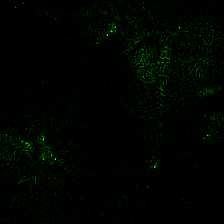

In [111]:
model.eval()
images, target = next(iter(data_loader))

images = images.to(device)
images.requires_grad = True # make sure this is set to True
target = target.to(device)

# compute output
outputs = model(images)

# compute attribution
target_outputs = torch.gather(outputs, 1, target.unsqueeze(-1))
gradients = torch.autograd.grad(torch.unbind(target_outputs), images, create_graph=False)[0]
attributions = gradients * images

# visualize
image = unnormalize(images[0]).permute(1,2,0).detach().cpu().numpy()*255.
attribution = attributions.squeeze(0).detach().permute(1,2,0).cpu().numpy()

show_pil_image(pil_image(image))

vis_attributions = pil_image(Visualize(
        attribution, image,
        clip_above_percentile=99,
        clip_below_percentile=0,
        overlay=False,
        ))
show_pil_image(vis_attributions)

## Computing Attributions for Training with Attribution Priors

In [112]:
def attribution_prior(attributions):
    return attributions.sum() # insert your own prior
    
model.train()
criterion = nn.CrossEntropyLoss()

# this is your training loop
for i, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    images.requires_grad = True # make sure this is set to True
    target = target.to(device)

    # compute output
    outputs = model(images)

    # compute attribution
    target_outputs = torch.gather(outputs, 1, target.unsqueeze(-1))
    gradients = torch.autograd.grad(torch.unbind(target_outputs), images, create_graph=True)[0] # set create_graph to True to allow
    attributions = gradients * images
    
    loss1 = criterion(outputs, target)
    loss2 = attribution_prior(attributions)    
    
    loss = loss1 + 0.1*loss2 # set weighting factor for loss2

    #optimizer.zero_grad()
    loss.backward()
    #optimizer.step()
    print(loss)
    break

tensor(8.6539, device='cuda:0', grad_fn=<AddBackward0>)
